In [4]:
# import PyQt5
# %matplotlib qt
%matplotlib inline 
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
import cv2
from scipy.interpolate import interpn
from tqdm.auto import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.transforms as mtransforms

In [74]:
def plot_2fig(fig1, fig2, name=None, title1=None, title2=None):
    fig = plt.figure(figsize=(10, 6))
    fig.add_subplot(1, 2, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(title1)
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()

In [75]:
def normalize_tiff(img):
    return img/(2.0**16.0 - 1.0)

In [76]:
def convert_xyz(img):
    M_RGB_XYZ = np.array([[0.4124564, 0.3575761, 0.1804375],
     [0.2126729, 0.7151522, 0.0721750],
     [0.0193339, 0.1191920, 0.9503041]])
    xyz = np.matmul(img, M_RGB_XYZ)
    lumi_channel = xyz[:, :, 1]
    return lumi_channel

In [77]:
I = []
h = 0
w = 0
for id in range(1, 8, 1):
    img = skimage.io.imread('data/input_{}.tif'.format(id))
    img = normalize_tiff(img)
    print(img.min(), img.max())
    luminance = convert_xyz(img)
    if id == 1:
        h, w = luminance.shape
    I.append(luminance.flatten())
I = np.stack(I, axis=0)
print(I.shape)

0.0014953841458762494 0.609399557488365
0.0 0.7927977416647592
0.0 0.5464103150988021
0.0 0.6795910582131686
0.0 0.6689555199511711
0.0 0.660669871061265
0.0 0.6504768444342718
(7, 159039)


In [78]:
h, w

(431, 369)

In [79]:
U, S, Vh = np.linalg.svd(I, full_matrices=False)
S = np.diag(S)
print(U.shape, S.shape, Vh.shape)

(7, 7) (7, 7) (7, 159039)


In [80]:
singular_vals = np.sqrt(S)[:3, :3]
print(singular_vals)

[[17.57036761  0.          0.        ]
 [ 0.          6.05435875  0.        ]
 [ 0.          0.          5.0608677 ]]


In [81]:
Le = np.matmul(U[:, :3], singular_vals)
Be = np.matmul(singular_vals, Vh[:3, :])
print(Le.shape, Be.shape)

(7, 3) (3, 159039)


In [82]:
Ae = np.linalg.norm(Be, axis=0)
Ne = Be / Ae
print(Ae.shape, Ne.shape)

(159039,) (3, 159039)


In [83]:
Ae = np.reshape(Ae, (h, w))
Ne = np.reshape(Ne, (3, h, w))
print(f'reshaped albedo {Ae.shape}, reshaped normal map {Ne.shape}')

reshaped albedo (431, 369), reshaped normal map (3, 431, 369)


In [84]:
Ne.min(), Ne.max() # in the range [-1, 1]

(-0.9999994445523214, 0.9814213518282867)

In [85]:
def map_normal(normal_img):
    return (normal_img + 1.0)/2.0

In [86]:
Ne_vis = map_normal(Ne)
Ne_vis = np.transpose(Ne_vis, (1, 2, 0))
Ne_vis.min(), Ne_vis.max() # in the range [-1, 1]

(2.7772383931479183e-07, 0.9907106759141433)

In [87]:
Q = np.array([[4, -5, -2], [5, -6, -2], [-8, 9, 3]])
print(Q.shape, Le.shape, Be.shape)
Lq = np.matmul(Q, Le.T)
Q_inv = np.linalg.inv(Q)
Bq = np.matmul(Q_inv, Be)

# get A, B
Aq = np.linalg.norm(Bq, axis=0)
Nq = Bq / Aq
print(Aq.shape, Nq.shape)

Aq = np.reshape(Aq, (h, w))
Nq = np.reshape(Nq, (3, h, w))
print(f'reshaped albedo {Aq.shape}, reshaped normal map {Nq.shape}')

(3, 3) (7, 3) (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (3, 431, 369)


In [88]:
Nq_vis = map_normal(Nq)
Nq_vis = np.transpose(Nq_vis, (1, 2, 0))
Nq_vis.min(), Nq_vis.max() # in the range [-1, 1]

(0.005826317666189629, 0.9995537815358511)

In [89]:
plot_2fig(Ae, Ne_vis, 'sv_e.png', 'Albedo A_E', 'Normal N_E')
plot_2fig(Aq, Nq_vis, 'sv_q.png', 'Albedo A_Q', 'Normal N_Q')

### Enforcing integrability

In [90]:
def decompose_pseudo_normal(B):
    # input shape B: (3, HxW)
    # returns albedo and norm
    print(f'check B {B.shape}')
    A = np.linalg.norm(B, axis=0)
    N = B / A
    print(A.shape, N.shape)

    A = np.reshape(A, (h, w))
    N = np.reshape(N.T, (h, w, 3))
    print(f'reshaped albedo {A.shape}, reshaped normal map {N.shape}')
    
    N_vis = map_normal(N)
    print(N_vis.min(), N_vis.max())
    
    return A, N_vis

In [91]:
be = np.reshape(np.transpose(Be), (h, w, 3))

# apply blur
sigma = 10.0
be_blur = []
for i in range(3):
    channel_blur = scipy.ndimage.gaussian_filter(be[:, :, i], sigma)
    be_blur.append(channel_blur)
be_blur = np.stack(be_blur, axis=2)
print(be_blur.shape)

# x and y gradients 
dx = np.gradient(be_blur, axis=1)
dy = np.gradient(be_blur, axis=0)
print(dx.shape, dy.shape)

(431, 369, 3)
(431, 369, 3) (431, 369, 3)


In [92]:
be_allpix = np.reshape(be, (-1, 3))
dx_allpix = np.reshape(dx, (-1, 3))
dy_allpix = np.reshape(dy, (-1, 3))
print(be_allpix.shape)
# A
A1 = (be_allpix[:, 0] * dx_allpix[:, 1]) - (be_allpix[:, 1] * dx_allpix[:, 0])
A2 = (be_allpix[:, 0] * dx_allpix[:, 2]) - (be_allpix[:, 2] * dx_allpix[:, 0])
A3 = (be_allpix[:, 1] * dx_allpix[:, 2]) - (be_allpix[:, 2] * dx_allpix[:, 1])
A4 = -(be_allpix[:, 0] * dy_allpix[:, 1]) + (be_allpix[:, 1] * dy_allpix[:, 0])
A5 = -(be_allpix[:, 0] * dy_allpix[:, 2]) + (be_allpix[:, 2] * dy_allpix[:, 0])
A6 = -(be_allpix[:, 1] * dy_allpix[:, 2]) + (be_allpix[:, 2] * dy_allpix[:, 1])

A_mat = np.stack((A1, A2, A3, A4, A5, A6), axis=1)
A_mat.shape

(159039, 3)


(159039, 6)

In [93]:
u, s, vh = np.linalg.svd(A_mat, full_matrices=False)
print(u.shape, vh.shape)
x = vh[-1, :] # null space, last row of vh
print(x)
delta = np.array([[-x[2], x[5], 1], [x[1], -x[4], 0], [-x[0], x[3], 0]])
print(delta)

(159039, 6) (6, 6)
[ 0.15026123 -0.54133514 -0.08563682 -0.77665655 -0.22254612 -0.15595511]
[[ 0.08563682 -0.15595511  1.        ]
 [-0.54133514  0.22254612  0.        ]
 [-0.15026123 -0.77665655  0.        ]]


In [94]:
delta_inv = np.linalg.inv(delta)
print(delta_inv.shape, be.shape)
be_integrate = np.matmul(delta_inv, Be)
# print(be_integrate.shape)
# # try hint
# G_f = np.array([[1, 0, 0], [0, 1, 0], [1.0, 2.0, -1]])
# G_temp = np.linalg.inv(G_f)
# be_integrate_ = np.matmul(G_temp, be_integrate)
# A_int, N_int = decompose_pseudo_normal(be_integrate_)

(3, 3) (431, 369, 3)


### modified for entropy minimization

In [95]:
# Apply GBR and return albedo and normals
def apply_GBR(be_integrate, lamda=-1, mu=0, vu=0):
    print(f'lambda {lamda}, mu {mu}, v {vu}')
    G_f = np.array([[1, 0, 0], [0, 1, 0], [mu, vu, lamda]])
    G_temp = np.linalg.inv(G_f)
    be_integrate_ = np.matmul(G_temp, be_integrate)
    A_int, N_int = decompose_pseudo_normal(be_integrate_)
    A_int = (A_int - A_int.min()) / (A_int.max() - A_int.min())
    return A_int, N_int

In [96]:
lamda_values = np.arange(0, 5, 1)
mu_values = np.arange(-5, 5, 1)
v_values = np.arange(-5, 5, 1)
min_entropy = 10.0
req_lamda = 6.0
req_mu = 6.0
req_vu = 6.0

for l in lamda_values:
    if l == 0:
        continue
    for m in mu_values:
        for v in v_values:
            Albedo, _ = apply_GBR(be_integrate, l, m, v)
            print(Albedo.min(), Albedo.max())
            hist = np.histogram(Albedo, bins=256, range=(1e-3, 1.0))[0]
            hist = hist / hist.sum()
            entropy = -(hist * np.log(hist+1e-4)).sum()
            print(entropy)
            
            if entropy < min_entropy:
                min_entropy = entropy
                req_lamda = l
                req_mu = m
                req_vu = v

print(f'min_entropy {min_entropy}, lambda {req_lamda}, mu {req_mu}, v {req_vu}')

lamda_values = np.linspace(req_lamda-1.0, req_lamda+1.0, num=8)
mu_values = np.linspace(req_mu-1.0, req_mu+1.0, num=8)
v_values = np.linspace(req_vu-1.0, req_vu+1.0, num=8)

for l in lamda_values:
    if l == 0:
        continue
    for m in mu_values:
        for v in v_values:
            Albedo, _ = apply_GBR(be_integrate, l, m, v)
            print(Albedo.min(), Albedo.max())
            hist = np.histogram(Albedo, bins=256, range=(1e-3, 1.0))[0]
            hist = hist / hist.sum()
            entropy = -(hist * np.log(hist+1e-4)).sum()
            print(entropy)
            
            if entropy < min_entropy:
                min_entropy = entropy
                req_lamda = l
                req_mu = m
                req_vu = v

print(f'min_entropy {min_entropy}, lambda {req_lamda}, mu {req_mu}, v {req_vu}')

lambda 1, mu -5, v -5
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.816428628792949e-07 0.9999897163897662
0.0 1.0
4.241762180949345
lambda 1, mu -5, v -4
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.807706047247009e-07 0.9999637818642181
0.0 1.0
4.215500656316569
lambda 1, mu -5, v -3
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.798998057917395e-07 0.9999325018712257
0.0 1.0
4.205789161247537
lambda 1, mu -5, v -2
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.790304629717859e-07 0.9999134208298515
0.0 1.0
4.210288786921067
lambda 1, mu -5, v -1
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.781625727676378e-07 0.9999559344119815
0.0 1.0
4.191073697833216
lambda 1, mu -5, v 0
check B (3, 15

(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.949234522297566e-07 0.999927853842294
0.0 1.0
4.154331127684305
lambda 1, mu 0, v -4
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.940288759833436e-07 0.9999471127484345
0.0 1.0
4.187975000013149
lambda 1, mu 0, v -3
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.931358089185991e-07 0.9997977597358279
0.0 1.0
4.231354943215704
lambda 1, mu 0, v -2
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.922442478158764e-07 0.9999624460227672
0.0 1.0
4.293426041209217
lambda 1, mu 0, v -1
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.913541890669507e-07 0.9999781512032834
0.0 1.0
4.331525401363851
lambda 1, mu 0, v 0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431

(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
3.1195773266823323e-06 0.9999560797933843
0.0 1.0
4.226804049448423
lambda 2, mu -5, v -2
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
3.116100003863753e-06 0.9999411789496382
0.0 1.0
4.228946053974628
lambda 2, mu -5, v -1
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
3.112628491952485e-06 0.9999787790958246
0.0 1.0
4.21578867320054
lambda 2, mu -5, v 0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
3.109162777958918e-06 0.9999412846337594
0.0 1.0
4.21774564618271
lambda 2, mu -5, v 1
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
3.1057028489489547e-06 0.9999633630050866
0.0 1.0
4.224143049212857
lambda 2, mu -5, v 2
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo 

4.147950981021432
lambda 2, mu 0, v 2
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
3.154749582234828e-06 0.9960638868906079
0.0 1.0
4.297089079974932
lambda 2, mu 0, v 3
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
3.1512133021882605e-06 0.9974223472521813
0.0 1.0
4.354731511064418
lambda 2, mu 0, v 4
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
3.1476829646659432e-06 0.9983092264254246
0.0 1.0
4.34187425031955
lambda 2, mu 1, v -5
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.0968781422038276e-06 0.9999762364834629
0.0 1.0
4.151047202884912
lambda 2, mu 1, v -4
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.1672958374897568e-06 0.9999318686946694
0.0 1.0
4.1478307748219905
lambda 2, mu 1, v -3


(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.050427476507082e-06 0.9999575558529576
0.0 1.0
4.274723514226657
lambda 3, mu -4, v -3
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.042551037228506e-06 0.9999420425771004
0.0 1.0
4.254261077214731
lambda 3, mu -4, v -2
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.034687789397864e-06 0.9999623826765331
0.0 1.0
4.247697272984672
lambda 3, mu -4, v -1
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.026837703483224e-06 0.999986022232057
0.0 1.0
4.237335121738665
lambda 3, mu -4, v 0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.019000750063675e-06 0.9999630518997
0.0 1.0
4.238011218392287
lambda 3, mu -4, v 1
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (43

(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
6.061144998126267e-07 0.9999793049396346
0.0 1.0
4.099525648482146
lambda 3, mu 1, v 0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
4.3510798020118813e-07 0.9995802578669157
0.0 1.0
4.13999974952305
lambda 3, mu 1, v 1
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
3.228849743686091e-07 0.9704427774477749
0.0 1.0
4.1772321812524185
lambda 3, mu 1, v 2
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
2.694456012752866e-07 0.9673701925982717
0.0 1.0
4.220174768933238
lambda 3, mu 1, v 3
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
2.7478991720952806e-07 0.9752211271028239
0.0 1.0
4.2842084625703665
lambda 3, mu 1, v 4
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431

4.2478115808767045
lambda 4, mu -4, v 2
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
2.2062753688989467e-06 0.9999663323904469
0.0 1.0
4.221783924801653
lambda 4, mu -4, v 3
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.2436363034828979e-05 0.9999608976514017
0.0 1.0
4.186281842099825
lambda 4, mu -4, v 4
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
2.0401042032935912e-06 0.9999514371168947
0.0 1.0
4.156900191692292
lambda 4, mu -3, v -5
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.259019207833223e-05 0.9999971526140541
0.0 1.0
4.334206681655568
lambda 4, mu -3, v -4
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.2576095551164457e-05 0.9999824967972749
0.0 1.0
4.294771325650418
lambda 4, mu -3

(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
4.430799072085989e-08 0.9999703963316382
0.0 1.0
4.106150204929753
lambda 4, mu 2, v -3
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
5.661882912511018e-08 0.9999549555463301
0.0 1.0
4.099582465597986
lambda 4, mu 2, v -2
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.147191039003076e-08 0.9999778377830633
0.0 1.0
4.1087904993993405
lambda 4, mu 2, v -1
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
8.88672339605101e-08 0.9999893841552784
0.0 1.0
4.141062017546799
lambda 4, mu 2, v 0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.0880479889285866e-07 0.9997899197596143
0.0 1.0
4.1885163243366845
lambda 4, mu 2, v 1
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (4

(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.886913532817452e-07 0.999999870693781
0.0 1.0
4.4102415632354255
lambda 1.0, mu -0.4285714285714286, v 1.0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.884386072909422e-07 0.99999990271603
0.0 1.0
4.446157492945463
lambda 1.0, mu -0.1428571428571429, v -1.0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.909726451038601e-07 0.9999802692367485
0.0 1.0
4.372143770602781
lambda 1.0, mu -0.1428571428571429, v -0.7142857142857143
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.907188018241307e-07 0.9999977358113943
0.0 1.0
4.363993764348256
lambda 1.0, mu -0.1428571428571429, v -0.4285714285714286
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.90465080668934e-07 0.9999911219

(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.925026817012792e-07 0.9293037825555528
0.0 1.0
4.250701535400378
lambda 1.0, mu 1.0, v 1.0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.897491706709836e-07 0.8936074170733719
0.0 1.0
4.2608906202361405
lambda 1.2857142857142856, mu -1.0, v -1.0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.303749463832382e-06 0.9999991475427834
0.0 1.0
4.35029359186321
lambda 1.2857142857142856, mu -1.0, v -0.7142857142857143
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.3033316622612645e-06 0.9999989688457008
0.0 1.0
4.300704766803957
lambda 1.2857142857142856, mu -1.0, v -0.4285714285714286
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.3029140614184698e-06 0.9999990498309972
0.0 

check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.348453124716542e-07 0.9709067028437066
0.0 1.0
4.234824517456985
lambda 1.2857142857142856, mu 0.1428571428571428, v 0.7142857142857142
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.2917719449667686e-07 0.9743314141443691
0.0 1.0
4.290240973868735
lambda 1.2857142857142856, mu 0.1428571428571428, v 1.0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.2363193324649302e-07 0.9778451662993208
0.0 1.0
4.349406141398144
lambda 1.2857142857142856, mu 0.4285714285714284, v -1.0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.3100497773810282e-06 0.9999733936496531
0.0 1.0
4.192614601334419
lambda 1.2857142857142856, mu 0.4285714285714284, v -0.7142857142857143
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo

1.9475752985886885e-06 0.9999993613796077
0.0 1.0
4.206918812401709
lambda 1.5714285714285714, mu -0.7142857142857143, v 0.1428571428571428
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.94695117633481e-06 0.9999994108330766
0.0 1.0
4.200501339284386
lambda 1.5714285714285714, mu -0.7142857142857143, v 0.4285714285714284
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.946327354063193e-06 0.9999994581849208
0.0 1.0
4.214879976881657
lambda 1.5714285714285714, mu -0.7142857142857143, v 0.7142857142857142
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.9457038314407704e-06 0.9999995034351379
0.0 1.0
4.245154618869834
lambda 1.5714285714285714, mu -0.7142857142857143, v 1.0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.945080608467542e-06 0.9999995465837268
0

7.590318564787424e-07 0.9999929555039316
0.0 1.0
4.154367314213165
lambda 1.5714285714285714, mu 0.7142857142857142, v -0.1428571428571429
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.294680836045231e-07 0.9999861247424962
0.0 1.0
4.1750959051176295
lambda 1.5714285714285714, mu 0.7142857142857142, v 0.1428571428571428
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.481130583353313e-07 0.9939864936828602
0.0 1.0
4.200241971732025
lambda 1.5714285714285714, mu 0.7142857142857142, v 0.4285714285714284
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
8.149667645174219e-07 0.9747258591785952
0.0 1.0
4.199437039406359
lambda 1.5714285714285714, mu 0.7142857142857142, v 0.7142857142857142
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
9.300291439751085e-07 0.948540

2.7271571673703754e-06 0.9999991583934582
0.0 1.0
4.090622424652398
lambda 1.8571428571428572, mu -0.1428571428571429, v -0.4285714285714286
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
2.726282098519661e-06 0.9999926031388489
0.0 1.0
4.027821190763858
lambda 1.8571428571428572, mu -0.1428571428571429, v -0.1428571428571429
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
2.7254074506100068e-06 0.9999921282736826
0.0 1.0
3.961070569878664
lambda 1.8571428571428572, mu -0.1428571428571429, v 0.1428571428571428
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
2.7245332236969233e-06 0.9968171822217894
0.0 1.0
3.956629638067876
lambda 1.8571428571428572, mu -0.1428571428571429, v 0.4285714285714284
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
2.7236594172808104e-06 

4.249582034845294
lambda 2.142857142857143, mu -1.0, v -0.7142857142857143
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
3.620340563170732e-06 0.9999994834569828
0.0 1.0
4.216920945224592
lambda 2.142857142857143, mu -1.0, v -0.4285714285714286
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
3.619180576952541e-06 0.999999475372459
0.0 1.0
4.197510779564045
lambda 2.142857142857143, mu -1.0, v -0.1428571428571429
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
3.6180211482328417e-06 0.9999995399832811
0.0 1.0
4.190876709182528
lambda 2.142857142857143, mu -1.0, v 0.1428571428571428
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
3.6168622766230563e-06 0.9999995944515665
0.0 1.0
4.192393465304293
lambda 2.142857142857143, mu -1.0, v 0.4285714285714284
check B (3, 15

4.140442048273923
lambda 2.142857142857143, mu 0.4285714285714284, v -1.0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.876504696802122e-07 0.9999791751895406
0.0 1.0
4.093442867808754
lambda 2.142857142857143, mu 0.4285714285714284, v -0.7142857142857143
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
8.952095912895253e-07 0.9999994643100636
0.0 1.0
4.068255056708253
lambda 2.142857142857143, mu 0.4285714285714284, v -0.4285714285714286
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.0135347838780007e-06 0.9999932075043183
0.0 1.0
4.053954483131871
lambda 2.142857142857143, mu 0.4285714285714284, v -0.1428571428571429
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.0601271912547006e-06 0.9999906553044854
0.0 1.0
4.053339528026918
lambda 2.142857142857143, m

4.645650757195696e-06 0.9999997916827348
0.0 1.0
4.163736673691951
lambda 2.4285714285714284, mu -0.4285714285714286, v -1.0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
4.660574480952473e-06 0.9999998700583035
0.0 1.0
4.115985284345821
lambda 2.4285714285714284, mu -0.4285714285714286, v -0.7142857142857143
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
4.659079521462939e-06 0.9999998843631518
0.0 1.0
4.082119526519445
lambda 2.4285714285714284, mu -0.4285714285714286, v -0.4285714285714286
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
4.6575852813424135e-06 0.999999897188756
0.0 1.0
4.059665939351816
lambda 2.4285714285714284, mu -0.4285714285714286, v -0.1428571428571429
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
4.656091759869252e-06 0.999999908535115

8.816195322114417e-07 0.9635639271333958
0.0 1.0
4.164531535473397
lambda 2.4285714285714284, mu 1.0, v -1.0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
6.980026842073883e-07 0.9999757837560629
0.0 1.0
4.112177612210628
lambda 2.4285714285714284, mu 1.0, v -0.7142857142857143
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.020632503684787e-07 0.99999962194639
0.0 1.0
4.117536849050976
lambda 2.4285714285714284, mu 1.0, v -0.4285714285714286
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
6.25676208898529e-07 0.9999928088892337
0.0 1.0
4.130446511460728
lambda 2.4285714285714284, mu 1.0, v -0.1428571428571429
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
5.566116567101709e-07 0.9999911076233676
0.0 1.0
4.147135222994246
lambda 2.4285714285714284, mu 1.0, v 0.

5.817940368801899e-06 0.9985313763564683
0.0 1.0
4.070094442318632
lambda 2.7142857142857144, mu -0.1428571428571429, v 0.7142857142857142
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
5.816074767961421e-06 0.9985788662192725
0.0 1.0
4.092897024673485
lambda 2.7142857142857144, mu -0.1428571428571429, v 1.0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
5.8142100644587025e-06 0.998625565137189
0.0 1.0
4.121375664664952
lambda 2.7142857142857144, mu 0.1428571428571428, v -1.0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
3.7993445389794545e-08 0.9999814621195742
0.0 1.0
4.053656962855681
lambda 2.7142857142857144, mu 0.1428571428571428, v -0.7142857142857143
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
3.6583819584823374e-08 0.9999995205113834
0.0 1.0
4.03592

(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.093519993672803e-06 0.9999995926136649
0.0 1.0
4.17743155930339
lambda 3.0, mu -1.0, v -0.1428571428571429
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.091247560764291e-06 0.9999996255783901
0.0 1.0
4.173953410970171
lambda 3.0, mu -1.0, v 0.1428571428571428
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.088976219538079e-06 0.9999996533683437
0.0 1.0
4.172910075573606
lambda 3.0, mu -1.0, v 0.4285714285714284
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
5.598850521149057e-06 0.999999675983523
0.0 1.0
4.1736753311072885
lambda 3.0, mu -1.0, v 0.7142857142857142
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
7.084436809801087e-06 0.9999996934239261
0.0 1.0
4.1759521789460

(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
5.743682821024443e-07 0.9999995989914251
0.0 1.0
4.065008389049918
lambda 3.0, mu 0.4285714285714284, v -0.4285714285714286
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
6.289073030130155e-07 0.9999932077196547
0.0 1.0
4.069651511917041
lambda 3.0, mu 0.4285714285714284, v -0.1428571428571429
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
6.872399496704595e-07 0.9999946180596134
0.0 1.0
4.0799084458274875
lambda 3.0, mu 0.4285714285714284, v 0.1428571428571428
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
6.692693335086375e-07 0.9980061589544913
0.0 1.0
4.0944998627075835
lambda 3.0, mu 0.4285714285714284, v 0.4285714285714284
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
6.13

In [97]:
A_int, N_int = apply_GBR(be_integrate, 0.8571428571428571, -4.0, -6.0)

lambda 0.8571428571428571, mu -4.0, v -6.0
check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
5.768455196841771e-07 0.9999162738432723


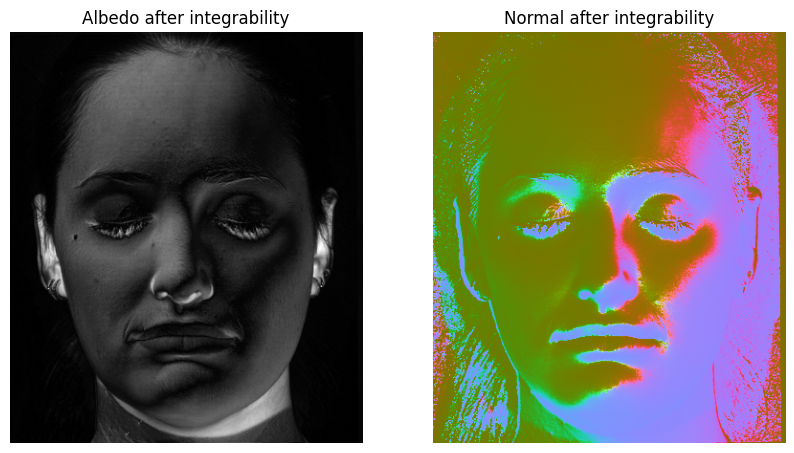

0.0 1.0


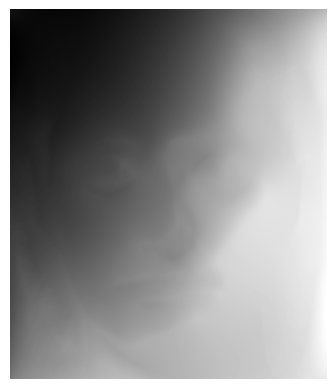

In [113]:
%matplotlib inline 

A_int.min(), A_int.max()
A_int = (A_int - A_int.min()) / (A_int.max() - A_int.min())
plot_2fig(A_int, N_int, 'img3_entropy_min.png', 'Albedo after integrability', 'Normal after integrability')
eps = 1
zx = N_int[:, :, 0]/(N_int[:, :, 2] + eps)
zy = N_int[:, :, 1]/(N_int[:, :, 2] + eps)

Z = integrate_frankot(zx, zy)
Z.min(), Z.max()

Z = normalize_01(Z)
print(Z.min(), Z.max())
plt.imshow(Z, cmap='gray')
plt.axis('off')
plt.savefig('depth_img3_entopy_min.png')

In [57]:
A_int.min(), A_int.max()
A_int = (A_int - A_int.min()) / (A_int.max() - A_int.min())

In [58]:
plot_2fig(A_int, N_int, 'sv_integrability_gbr.png', 'Albedo after integrability, sigma=6.0, u=1, v=2', 'Normal after integrability')

In [59]:
N_int.shape

(431, 369, 3)

In [60]:
eps = 1e-12
zx = N_int[:, :, 0]/(N_int[:, :, 2] + eps)
zy = N_int[:, :, 1]/(N_int[:, :, 2] + eps)

In [61]:
import sys
sys.path.append("/Users/prachigarg/Desktop/assgn5/src") 
from cp_hw5 import integrate_poisson, integrate_frankot, load_sources

In [62]:
Z = integrate_frankot(zx, zy)
Z.min(), Z.max()

(-68.7411730749343, 59.86588674286214)

In [63]:
def normalize_01(depth):
    return (depth - depth.min()) / (depth.max() - depth.min())

In [64]:
Z = normalize_01(Z)
print(Z.min(), Z.max())
plt.imshow(Z, cmap='gray')
plt.axis('off')
plt.savefig('depth_uncalibrated_gbr.png')

0.0 1.0


In [114]:
import PyQt5
%matplotlib qt
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
# Z is an HxW array of surface depths
H, W = Z.shape
x, y = np.meshgrid(np.arange(0,W), np.arange(0,H))
# set 3D figure
fig = plt.figure()
ax = fig.gca(projection='3d')
# add a light and shade to the axis for visual effect
# (use the ‘-’ sign since our Z-axis points down)
ls = LightSource()
color_shade = ls.shade(-Z, plt.cm.gray)
# display a surface
# (control surface resolution using rstride and cstride)
surf = ax.plot_surface(x, y, -Z, facecolors=color_shade, rstride=4, cstride=4)
# ax.view_init(elev=10, azim=90)
# turn off axis
plt.axis('off')
plt.show()

2023-11-23 19:18:30.868 python[4546:220483] +[CATransaction synchronize] called within transaction
2023-11-23 19:18:31.070 python[4546:220483] +[CATransaction synchronize] called within transaction
2023-11-23 19:18:40.222 python[4546:220483] +[CATransaction synchronize] called within transaction
2023-11-23 19:18:41.279 python[4546:220483] +[CATransaction synchronize] called within transaction
2023-11-23 19:18:41.542 python[4546:220483] +[CATransaction synchronize] called within transaction


### Calibrated

In [105]:
L = load_sources() # A = 7x3
print(f'light matrix \n {L}, {L.shape}')

light matrix 
 [[-0.1418 -0.1804 -0.9267]
 [ 0.1215 -0.2026 -0.9717]
 [-0.069  -0.0345 -0.838 ]
 [ 0.067  -0.0402 -0.9772]
 [-0.1627  0.122  -0.979 ]
 [ 0.      0.1194 -0.9648]
 [ 0.1478  0.1209 -0.9713]], (7, 3)


In [106]:
I.shape # b = 7xN

(7, 159039)

In [107]:
B_calibrated = np.linalg.lstsq(L, I)[0]
B_calibrated.shape

/var/folders/hd/n1h1bh010cv5cm5k41bsp7y00000gp/T/ipykernel_19837/3291473867.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B_calibrated = np.linalg.lstsq(L, I)[0]


(3, 159039)

In [108]:
A_calib, N_calib = decompose_pseudo_normal(B_calibrated)
plot_2fig(A_calib, N_calib, 'sv_calibrated.png', 'Albedo, calibrated', 'Normal, calibrated')

check B (3, 159039)
(159039,) (3, 159039)
reshaped albedo (431, 369), reshaped normal map (431, 369, 3)
1.592430933783362e-06 0.9933777487941959


In [121]:
eps = 1e-17
zx = N_int[:, :, 0]/(N_int[:, :, 2] + eps)
zy = N_int[:, :, 1]/(N_int[:, :, 2] + eps)

Z = integrate_frankot(zx, zy)
Z.min(), Z.max()

# Z = normalize_01(Z)
print(Z.min(), Z.max())
plt.imshow(Z, cmap='gray')
plt.axis('off')
plt.savefig('depth_calibrated.png')

-43.448573291274194 57.23876533866211


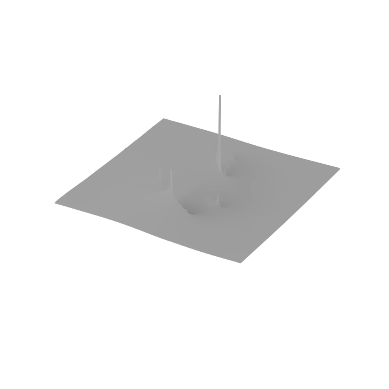

In [71]:
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
# Z is an HxW array of surface depths
H, W = Z.shape
x, y = np.meshgrid(np.arange(0,W), np.arange(0,H))
# set 3D figure
fig = plt.figure()
ax = fig.gca(projection='3d')
# add a light and shade to the axis for visual effect
# (use the ‘-’ sign since our Z-axis points down)
ls = LightSource()
color_shade = ls.shade(-Z, plt.cm.gray)
# display a surface
# (control surface resolution using rstride and cstride)
surf = ax.plot_surface(x, y, -Z, facecolors=color_shade, rstride=4, cstride=4)
# ax.view_init(elev=10, azim=90)
# turn off axis
plt.axis('off')
plt.show()